In [ ]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
station_day = pd.read_csv("/content/station_day.csv")

In [ ]:
sd=pd.DataFrame(station_day)

In [ ]:

sd["Date"]= pd.to_datetime(sd["Date"])

In [ ]:
sd.drop(['AQI_Bucket', 'StationId'], axis=1, inplace=True)

In [ ]:
sd=sd.dropna()

In [ ]:
sd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10314 entries, 1 to 106147
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     10314 non-null  datetime64[ns]
 1   PM2.5    10314 non-null  float64       
 2   PM10     10314 non-null  float64       
 3   NO       10314 non-null  float64       
 4   NO2      10314 non-null  float64       
 5   NOx      10314 non-null  float64       
 6   NH3      10314 non-null  float64       
 7   CO       10314 non-null  float64       
 8   SO2      10314 non-null  float64       
 9   O3       10314 non-null  float64       
 10  Benzene  10314 non-null  float64       
 11  Toluene  10314 non-null  float64       
 12  Xylene   10314 non-null  float64       
 13  AQI      10314 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.2 MB


In [ ]:
dates = sd['Date']
sd.drop('Date', axis=1,inplace=True) 
sd.head()
values = sd.values

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:

scaled = scaler.fit_transform(values)

In [ ]:
n_days = 7
n_features = 13
reframed = series_to_supervised(scaled, n_days, 1) 

In [ ]:

values = reframed.values 
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t)
7,0.109493,0.144032,0.005420,0.080425,0.036382,0.039358,0.025316,0.225432,0.782871,0.001209,...,0.102759,0.059883,0.048253,0.021097,0.286927,0.792976,0.001511,0.010771,0.000524,0.258876
8,0.105294,0.149564,0.004733,0.102014,0.044739,0.037727,0.029536,0.399940,0.723413,0.001330,...,0.083605,0.036503,0.052848,0.031646,0.168404,0.707147,0.001390,0.014747,0.000299,0.312130
9,0.119528,0.157158,0.025116,0.121050,0.065615,0.047474,0.023207,0.498660,0.688725,0.001753,...,0.105860,0.052975,0.053033,0.037975,0.145027,0.692421,0.001874,0.013628,0.000674,0.224852
10,0.086016,0.119273,0.009695,0.110139,0.051255,0.041952,0.018987,0.281418,0.851201,0.001028,...,0.079366,0.041420,0.050476,0.025316,0.207266,0.726433,0.001451,0.011273,0.000225,0.269231
11,0.097318,0.132314,0.019887,0.091023,0.049988,0.045028,0.033755,0.155599,0.675970,0.001270,...,0.100640,0.045161,0.055665,0.023207,0.244789,0.721996,0.001753,0.017179,0.000524,0.273669


In [ ]:
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]

In [ ]:
values = reframed.values 
# len(values)
#80:10:10
# 6188
# 2062
# 2062 
n_train_days = 8251
train = values[:n_train_days, :] 
val = values[n_train_days:1028+n_train_days,:]  
test=values[1028+n_train_days:,:]

# test
len(train) 
print(train.shape,val.shape,test.shape)
print(train.shape[0]+val.shape[0]+test.shape[0])

(8251, 104) (1028, 104) (1028, 104)
10307


In [ ]:
n_obs = n_days* n_features
print(n_obs)

91


In [ ]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]

val_X, val_y = val[:, :n_obs], val[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]  


In [ ]:
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
val_X = val_X.reshape((val_X.shape[0],n_days,n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))



In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional,Embedding,GRU,Dropout
import numpy as np 

def test_diff_strategies(units,loss_tmp,optmzr,val_X,val_y,test_X,test_y):

  model_lstm = Sequential()
  model_lstm.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
  model_lstm.add(Dropout(0.2))
  model_lstm.add(Dense(1))
  # model_lstm = Sequential()
  # model_lstm.add(LSTM(units,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
  # model_lstm.add(Dropout(0.25))
  # # model_lstm.add(Dense(34 ,'relu'))
  # # model_lstm.add(Dropout(0.25))
  # model_lstm.add(LSTM(units))
  # model_lstm.add(Dropout(0.25))
  # # model_lstm.add(Dense(15 ,'relu'))

  # model_lstm.add(Dense(1 ,'relu' ))
  model_lstm.compile(loss=loss_tmp, optimizer=optmzr)
  es=EarlyStopping(monitor='val_loss',patience=30,verbose =1)
  history = model_lstm.fit(train_X, train_y, epochs=250,batch_size=32,callbacks=es,validation_data=(val_X, val_y), verbose=2, shuffle=False)
  model_lstm.reset_states()
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='val')
  pyplot.legend() 
  pyplot.show()

  yhat = model_lstm.predict(val_X) 
  # print(len(yhat))
  fcp1=np.repeat(yhat,13,axis=1)
  # print(len(fcp1))
  inv_yhat=scaler.inverse_transform(fcp1)
  inv_yhat = inv_yhat[:,0]
  # print(inv_yhat)
  val_y = val_y.reshape((len(val_y), 1)) 
  # inv_y = concatenate((val_y, val_X[:, 1:]), axis=1)
  # print(inv_yhat)  
  fcp2=np.repeat(val_y,13,axis=1)
  inv_y = scaler.inverse_transform(fcp2) 
  inv_y = inv_y[:,0]
    
  validation_rmse = sqrt(mean_squared_error(inv_y, inv_yhat)) 
  yhat_test = model_lstm.predict(test_X)
  # test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
  # # test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  # inv_yhat_test = concatenate((yhat_test,test_X[:, 1:]), axis=1)
  fcp3=np.repeat(yhat_test,13,axis=1)
  inv_yhat_test = scaler.inverse_transform(fcp3) 
  # inv_yhat_test = scaler.inverse_transform(yhat_test)
  inv_yhat_test = inv_yhat_test[:,0]

  inv_yhat_test.reshape(inv_yhat_test.shape[0],1)

  test_y = test_y.reshape((len(test_y), 1))
  # inv_testy = concatenate((test_y, test_X[:, 1:]), axis=1) 
  fcp4=np.repeat(test_y,13,axis=1)
  inv_testy = scaler.inverse_transform(fcp4) 
  # inv_testy = scaler.inverse_transform(test_Y)
  inv_testy = inv_testy[:,0]

  inv_testy.reshape(inv_testy.shape[0],1)
  test_rmse=sqrt(mean_squared_error(inv_testy, inv_yhat_test))
  # epoch_list_temp=[]
  # batch_list_temp=[] 
  # validationrmse_list=[] 
  # testrmse_list=[]

  dict_of_values={'units':units,'optimizer':optmzr,'Loss':loss_tmp,'ValRMSE':validation_rmse,'TestRMSE':test_rmse}
  print(dict_of_values)
  return (dict_of_values,model_lstm,history)
  

Epoch 1/250
258/258 - 3s - loss: 0.0078 - val_loss: 0.0015 - 3s/epoch - 10ms/step
Epoch 2/250
258/258 - 1s - loss: 0.0051 - val_loss: 0.0013 - 956ms/epoch - 4ms/step
Epoch 3/250
258/258 - 1s - loss: 0.0045 - val_loss: 0.0012 - 945ms/epoch - 4ms/step
Epoch 4/250
258/258 - 1s - loss: 0.0041 - val_loss: 0.0011 - 873ms/epoch - 3ms/step
Epoch 5/250
258/258 - 1s - loss: 0.0035 - val_loss: 9.6032e-04 - 957ms/epoch - 4ms/step
Epoch 6/250
258/258 - 1s - loss: 0.0033 - val_loss: 8.6503e-04 - 877ms/epoch - 3ms/step
Epoch 7/250
258/258 - 1s - loss: 0.0029 - val_loss: 7.6533e-04 - 937ms/epoch - 4ms/step
Epoch 8/250
258/258 - 1s - loss: 0.0027 - val_loss: 6.9788e-04 - 865ms/epoch - 3ms/step
Epoch 9/250
258/258 - 1s - loss: 0.0025 - val_loss: 6.2341e-04 - 954ms/epoch - 4ms/step
Epoch 10/250
258/258 - 1s - loss: 0.0023 - val_loss: 5.6632e-04 - 952ms/epoch - 4ms/step
Epoch 11/250
258/258 - 1s - loss: 0.0021 - val_loss: 5.1710e-04 - 870ms/epoch - 3ms/step
Epoch 12/250
258/258 - 1s - loss: 0.0020 - val_l

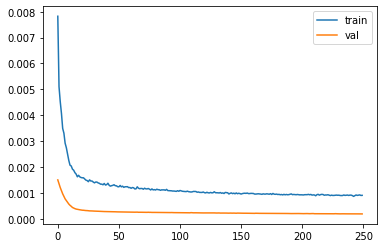

33/33 [==============================] - 0s 2ms/step
{'units': 30, 'optimizer': <keras.optimizers.optimizer_v2.adamax.Adamax object at 0x7fe27010ff50>, 'Loss': 'mse', 'ValRMSE': 9.958332992830364, 'TestRMSE': 19.582460987330283}


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import * 
from tensorflow.keras.losses import *
list_of_results=[]
# list_of_units = [6,7,90,30,128] 

list_of_units=[30] 

# list_of_losses = [MeanSquaredLogarithmicError(),Huber(),LogCosh(),'mae','mse']

list_of_losses=['mse'] 
# list_of_optmzrs=[ Adam(),SGD(),RMSprop(),Adadelta(),Adagrad(),Adamax(),Nadam(),Ftrl()]
list_of_optmzrs=[Adamax(learning_rate=0.0003)]#$,Nadam(learning_rate=0.0003),Adam(learning_rate=0.0003)]

for unit in list_of_units:
  for loss in list_of_losses:
    for op in list_of_optmzrs: 
      dict_to_be_stored,model,his=test_diff_strategies(unit,loss,op,val_X,val_y,test_X,test_y) 
      list_of_results.append(dict_to_be_stored)

In [ ]:

final_list= [] 
list_of_ops=[] 
list_of_units=[] 
list_of_loss=[] 
vali_list=[] 
test_list=[] 
# 'units':units,'optimizer':optmzr,'Loss':loss_tmp,'ValRMSE':validation_rmse,'TestRMSE':test_rmse

for result in list_of_results:
  list_of_units.append(result['units']) 
  list_of_ops.append(result['optimizer']) 
  list_of_loss.append(result['Loss']) 
  vali_list.append(result['ValRMSE']) 
  test_list.append(result['TestRMSE']) 
# final_list.append(list_of_ops)
# final_list.append(list_of_ops)
final_list=[list_of_units,list_of_ops,list_of_loss,vali_list,test_list]  
# final_list
print(final_list)

[[30], [<keras.optimizers.optimizer_v2.adamax.Adamax object at 0x7fe27010ff50>], ['mse'], [9.958332992830364], [19.582460987330283]]


In [ ]:
# df= pd.DataFrame(final_list) 
# df=df.T

In [ ]:
# df.to_csv("results.csv")

,0,1,2,3,4
0,128,<keras.optimizer_v2.adamax.Adamax object at 0x...,mae,15.582117,34.36616
1,128,<keras.optimizer_v2.nadam.Nadam object at 0x7f...,mae,15.778015,36.230118
2,128,<keras.optimizer_v2.adam.Adam object at 0x7ff8...,mae,15.564957,35.137842
3,128,<keras.optimizer_v2.adamax.Adamax object at 0x...,mse,15.515747,34.212508
4,128,<keras.optimizer_v2.nadam.Nadam object at 0x7f...,mse,15.901876,40.87206
5,128,<keras.optimizer_v2.adam.Adam object at 0x7ff8...,mse,15.828325,40.648863
6,30,<keras.optimizer_v2.adamax.Adamax object at 0x...,mae,15.624748,35.050159
7,30,<keras.optimizer_v2.nadam.Nadam object at 0x7f...,mae,15.694476,37.226947
8,30,<keras.optimizer_v2.adam.Adam object at 0x7ff8...,mae,15.460957,34.428307
9,30,<keras.optimizer_v2.adamax.Adamax object at 0x...,mse,15.647591,34.138623


In [ ]:
|# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout
# from keras.layers import InputLayer

# # model_lstm = Sequential()
# # model_lstm.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model_lstm.add(Dropout(0.2))
# # model_lstm.add(Dense(1))
# model_lstm = Sequential()

# # model_lstm.add(InputLayer())

# model_lstm.add(LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2])))

# model_lstm.add(Dense(34 ,'relu'))
# # model_lstm.add(Dropout(0.25))

# model_lstm.add(Dense(15 ,'relu'))

# model_lstm.add(Dense(1 ,'relu' ))

In [ ]:
# model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                12800     
                                                                 
 dense_10 (Dense)            (None, 34)                1734      
                                                                 
 dense_11 (Dense)            (None, 15)                525       
                                                                 
 dense_12 (Dense)            (None, 1)                 16        
                                                                 
Total params: 15,075
Trainable params: 15,075
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model_lstm.compile(
#     optimizer = 'adam',
#     loss = 'mse'
# )

In [ ]:
# from keras.callbacks import EarlyStopping

In [ ]:
  # model.compile(loss=loss_tmp, optimizer=optmzr)
# es=EarlyStopping(monitor='val_loss',patience=30,verbose =1)

In [ ]:
# history = model_lstm.fit(train_X, train_y, epochs=150,batch_size=32,validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/150
258/258 - 3s - loss: 0.0044 - val_loss: 9.3347e-04 - 3s/epoch - 13ms/step
Epoch 2/150
258/258 - 1s - loss: 0.0029 - val_loss: 9.8334e-04 - 882ms/epoch - 3ms/step
Epoch 3/150
258/258 - 1s - loss: 0.0027 - val_loss: 8.7607e-04 - 897ms/epoch - 3ms/step
Epoch 4/150
258/258 - 1s - loss: 0.0023 - val_loss: 8.2168e-04 - 960ms/epoch - 4ms/step
Epoch 5/150
258/258 - 1s - loss: 0.0022 - val_loss: 6.8433e-04 - 901ms/epoch - 3ms/step
Epoch 6/150
258/258 - 1s - loss: 0.0020 - val_loss: 9.6531e-04 - 884ms/epoch - 3ms/step
Epoch 7/150
258/258 - 1s - loss: 0.0022 - val_loss: 7.0007e-04 - 907ms/epoch - 4ms/step
Epoch 8/150
258/258 - 1s - loss: 0.0018 - val_loss: 6.2525e-04 - 878ms/epoch - 3ms/step
Epoch 9/150
258/258 - 1s - loss: 0.0018 - val_loss: 6.3457e-04 - 890ms/epoch - 3ms/step
Epoch 10/150
258/258 - 1s - loss: 0.0018 - val_loss: 6.3919e-04 - 896ms/epoch - 3ms/step
Epoch 11/150
258/258 - 1s - loss: 0.0018 - val_loss: 6.1939e-04 - 906ms/epoch - 4ms/step
Epoch 12/150
258/258 - 1s - loss

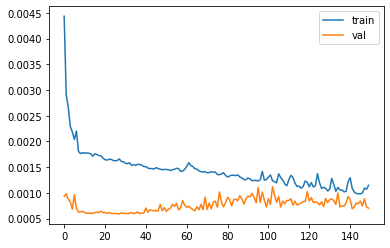

In [ ]:
# model_lstm.reset_states()
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='val')
# pyplot.legend() 
# pyplot.show()

In [ ]:
# import numpy as np
# yhat = model_lstm.predict(val_X) 
# # print(len(yhat))
# fcp1=np.repeat(yhat,13,axis=1)
# # print(len(fcp1))
# inv_yhat=scaler.inverse_transform(fcp1)
# inv_yhat = inv_yhat[:,0]
# # print(inv_yhat)
# val_y = val_y.reshape((len(val_y), 1)) 
# # inv_y = concatenate((val_y, val_X[:, 1:]), axis=1)
# # print(inv_yhat)  
# fcp2=np.repeat(val_y,13,axis=1)
# inv_y = scaler.inverse_transform(fcp2) 
# inv_y = inv_y[:,0]
  
# validation_rmse = sqrt(mean_squared_error(inv_y, inv_yhat)) 
# yhat_test = model_lstm.predict(test_X)
# # test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# # # test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # inv_yhat_test = concatenate((yhat_test,test_X[:, 1:]), axis=1)
# fcp3=np.repeat(yhat_test,13,axis=1)
# inv_yhat_test = scaler.inverse_transform(fcp3) 
# # inv_yhat_test = scaler.inverse_transform(yhat_test)
# inv_yhat_test = inv_yhat_test[:,0]

# inv_yhat_test.reshape(inv_yhat_test.shape[0],1)

# test_y = test_y.reshape((len(test_y), 1))
# # inv_testy = concatenate((test_y, test_X[:, 1:]), axis=1) 
# fcp4=np.repeat(test_y,13,axis=1)
# inv_testy = scaler.inverse_transform(fcp4) 
# # inv_testy = scaler.inverse_transform(test_Y)
# inv_testy = inv_testy[:,0]

# inv_testy.reshape(inv_testy.shape[0],1)
# test_rmse=sqrt(mean_squared_error(inv_testy, inv_yhat_test))
# # epoch_list_temp=[]
# # batch_list_temp=[] 
# # validationrmse_list=[] 
# # testrmse_list=[]

# dict_of_values={'ValRMSE':validation_rmse,'TestRMSE':test_rmse}
# print(dict_of_values)

{'ValRMSE': 17.922574337193286, 'TestRMSE': 44.04229392011688}
